In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D  
import scipy.misc
import scipy.io
from torch.optim import Adam, LBFGS
from scipy.stats import bernoulli, norm

In [2]:
torch.cuda.is_available()
device = torch.device("cuda")

In [3]:
def all_all_triangle(a):
    max_len = a / 2
    center_x = int(a//2)
    center_y = int(a//2)
    res = []
    dic = []
    for l1 in range(0, a):
        for l2 in range(0, a):
            for l3 in range(0, a):
                for l4 in range(0, a):
                    if ([l1, l2, l3, l4] not in dic) and ([l3, l4, l1, l2] not in dic):
                        dic.append([l1, l2, l3, l4])
                        img = np.zeros([a, a])
                        img[center_y, center_x] = 1
                        img[l1, l2] += 1
                        img[l3, l4] += 1
                        res.append(img)
                    
    return np.array(res)

def all_all_shuffle_triangle(a):
    max_len = a / 2
    center_x = int(a//2)
    center_y = int(a//2)
    res = []
    dic = []
    for l in range(a-center_x):
        for l1 in range(-l, l+1):
            for l2 in range(-l, l+1):
                for l3 in range(-l, l+1):
                    for l4 in range(-l, l+1):
                        if ([l1, l2, l3, l4] not in dic) and ([l3, l4, l1, l2] not in dic):
                            dic.append([l1, l2, l3, l4])
                            img = np.zeros([a, a])
                            img[center_x, center_y] = 1
                            img[int(center_x+l1), int(center_y+l2)] += 1
                            img[int(center_x+l3), int(center_y+l4)] += 1
                            res.append(img)
    return np.array(res)

def all_all_shuffle_triangle_v2(a):
    max_len = a / 2
    center_x = int(a//2)
    center_y = int(a//2)
    res = []
    dic = []
    for l in range(a-center_x):
        for l1 in range(-l, l+1):
            for l2 in range(-l, l+1):
                for l3 in range(-l, l+1):
                    for l4 in range(-l, l+1):
                        if ([l1, l2, l3, l4] not in dic) and ([l3, l4, l1, l2] not in dic):
                            dic.append([l1, l2, l3, l4])
    dic = np.array(dic)
    for i in range(len(dic)):
        l1, l2, l3, l4 = dic[i]
        img = np.zeros([a, a])
        img[center_x, center_y] = 1
        img[int(center_x+l1), int(center_y+l2)] += 1
        img[int(center_x+l3), int(center_y+l4)] += 1
    return np.array(res)
                    
                    

def stretch_triangle(a, b):
    max_len = a.shape[0]
    max_len = max_len * b
    res = np.zeros([max_len, max_len])
    index = np.where(a != 0)
    for i in range(len(index[0])):
        x1 = index[0][i]
        x2 = index[1][i]
        v = a[x1, x2]
        x1 = x1 * b + b / 2
        x2 = x2 * b + b / 2
        x1 = int(x1)
        x2 = int(x2)
        res[x1, x2] = v
    return res

def stretch_odd_triangle(a, b):
    max_len = a.shape[0]
    assert(max_len % 2 == 1)
    max_len = int((max_len-1) * b  + 1)
    res = np.zeros([max_len, max_len])
    index = np.where(a != 0)
    for i in range(len(index[0])):
        x1 = index[0][i]
        x2 = index[1][i]
        v = a[x1, x2]
        x1 = x1 * b
        x2 = x2 * b
        x1 = int(x1)
        x2 = int(x2)
        res[x1, x2] = v
    return res

def resize_triangle(a, b):
    current_size = a.shape[0]
    center_point = int(current_size / 2)
    ind = np.array(np.where(a != 0))
#     assert any(center_point in ind)
    res = np.zeros([b, b])
    center_v = a[center_point, center_point]
    new_center = b / 2
    res[int(new_center), int(new_center)] = center_v
    for i in range(len(ind[0])):
        if not (ind[0, i] == center_point and ind[1, i] == center_point):
            v = a[int(ind[0, i]), int(ind[1, i])]
            x = new_center + int(ind[0, i] - current_size / 2)
            y = new_center + int(ind[1, i] - current_size / 2)
            res[int(x), int(y)] = v
    return res

def resize_odd_triangle(a, b):
    current_size = a.shape[0]
    old_center = (current_size-1)/2
    assert(current_size % 2 == 1)
    assert(b%2==1)
    ind = np.array(np.where(a != 0))
#     assert any(center_point in ind)
    res = np.zeros([b, b])
    center_v = a[int(old_center), int(old_center)]
    new_center = (b-1)/2
    res[int(new_center), int(new_center)] = center_v
    for i in range(len(ind[0])):
        if not (ind[0, i] == old_center and ind[1, i] == old_center):
            v = a[int(ind[0, i]), int(ind[1, i])]
            x = new_center + int(ind[0, i] - old_center)
            y = new_center + int(ind[1, i] - old_center)
            res[int(x), int(y)] = v
    return res
    
        

In [4]:
def gkern(kernlen=21, std=3):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    gkern2d /= (2*np.pi*(std**2))
    return gkern2d

In [5]:
def resize_odd_triangle_index(a, b, index):
    current_size = a
    old_center = (current_size-1)/2
    res = np.zeros([b, b])
    new_center = (b-1)/2
    l1, l2, l3, l4 = index
    res[int(new_center), int(new_center)] = 1
    x1 = new_center - (l1 - old_center)
    y1 = new_center - (l2 - old_center)
    x2 = new_center - (l3 - old_center)
    y2 = new_center - (l4 - old_center)
    res[int(x1), int(y1)] += 1
    res[int(x2), int(y2)] += 1
    return res

def stretch_odd_triangle_index(a, b, index):
    current_size = a
    old_center = (current_size-1)/2
    assert(current_size % 2 == 1)
    new_size = int((current_size-1) * b  + 1)
    new_center = old_center*b
    res = np.zeros([new_size, new_size])
    res[int(new_center), int(new_center)] = 1
    res[int(index[0]*b+new_center), int(index[1]*b+new_center)] += 1
    res[int(index[2]*b+new_center), int(index[3]*b+new_center)] += 1
    return res

    

In [6]:
index_40 = np.load('20_index.npy')
index_40[0]

array([0, 0, 0, 0])

In [7]:
bound_len = np.max(np.abs(index_40), 1)
bound = 5
bound_index = np.where(bound_len <= bound)[0]
len(bound_index)

7381

In [8]:
w_all_test = [stretch_odd_triangle_index(21, 2, i) for i in index_40[bound_index]]
w_all_test = np.array(w_all_test)

In [9]:
print(w_all_test.shape)

(7381, 41, 41)


In [10]:
w_all_test1 = all_all_shuffle_triangle(3)
w_all_test1 = [stretch_odd_triangle(w_, 2) for w_ in w_all_test1]
w_all_test1 = [resize_odd_triangle(w_, 41) for w_ in w_all_test1]
# w_all_test = all_all_triangle(20)
w_all_test1 = np.array(w_all_test1)
print(w_all_test1.shape)

(45, 41, 41)


(41, 41)


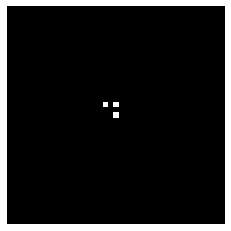

In [11]:
w1 = w_all_test[2,:,:]
plt.imshow(w1, cmap='gray')
plt.axis("off")
print(w1.shape)
# plt.imshow(w_all[100], cmap='gray')

(128, 128)


(-0.5, 127.5, 127.5, -0.5)

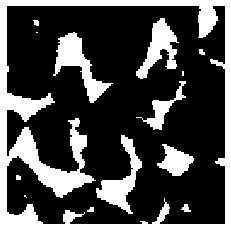

In [12]:
a1 = scipy.io.loadmat('sandstone_data.mat')
a1 = a1['Data']
a1 = a1[0,:].reshape([128, 128])
size = a1.shape
print(size)
plt.imshow(a1, cmap='gray')
plt.axis('off')

In [13]:
index = np.random.permutation(np.arange(len(w_all_test)))[:738]

In [14]:
weight_filter = gkern(3, 1)
weight_filter

array([[0.05854983, 0.09653235, 0.05854983],
       [0.09653235, 0.15915494, 0.09653235],
       [0.05854983, 0.09653235, 0.05854983]])

In [15]:
d1 = w_all_test[index]
d2 = d1[:,np.newaxis,:,:]

In [16]:
with torch.no_grad():
    aa = np.rot90(np.rot90(a1)).copy()
    inputs = torch.from_numpy(aa.reshape([1, 1, size[0], size[1]]))
    # inputs = torch.from_numpy(a.reshape([1, 1, size[0], size[1]]))
    inputs = inputs.type(torch.FloatTensor)
    inputs = Variable(inputs)
    inputs_inv = torch.ones(inputs.size()) - inputs
    inputs = inputs.to(device)
    inputs_inv = inputs_inv.to(device)

In [17]:
inputs.size()

torch.Size([1, 1, 128, 128])

In [18]:
# %% convert to pytorch code
with torch.no_grad():
    weights = torch.from_numpy(d2.reshape([d2.shape[0],1,d2.shape[2], d2.shape[3]]))
    weights = weights.type(torch.FloatTensor)
    weights = Variable(weights)
    weights = weights.to(device)
    bias = Variable(torch.Tensor([-2.0]))
    bias = bias.to(device)
    outputs = F.conv_transpose2d(weights, inputs, bias, padding=0)
    outputs = F.relu(outputs)
    print(outputs.size())
    outputs = torch.mean(outputs, dim=(1,2,3))
    # outputs = F.conv2d(inputs, weights, b+ias, padding=5)
    print(outputs[:20])
    outputs_inv = F.conv_transpose2d(weights, inputs_inv, bias, padding=0)
    outputs_inv = F.relu(outputs_inv)
    outputs_inv = torch.mean(outputs_inv, dim=(1,2,3))
    print(outputs_inv.size())

torch.Size([738, 1, 168, 168])
tensor([0.0050, 0.0105, 0.0067, 0.0162, 0.0021, 0.0067, 0.0162, 0.0016, 0.0127,
        0.0251, 0.0054, 0.0229, 0.0202, 0.0077, 0.0177, 0.0344, 0.0080, 0.0070,
        0.0237, 0.0105], device='cuda:0')
torch.Size([738])


In [19]:
# %% convert to pytorch code
# index = [0,1,2]
with torch.no_grad():
    d3 = w_all_test1[:, np.newaxis, :,:]
    weights_test = torch.from_numpy(d3.reshape([d3.shape[0],1,d3.shape[2], d3.shape[3]]))
    weights_test = weights_test.type(torch.FloatTensor)
    weights_test = Variable(weights_test)
    weights_test = weights_test.to(device)
    bias = Variable(torch.Tensor([-2.0]))
    bias = bias.to(device)
    outputs_test = F.conv_transpose2d(weights_test, inputs, bias, padding=0)
    outputs_test = F.relu(outputs_test)
    print(outputs_test.size())
    outputs_test = torch.mean(outputs_test, dim=(1,2,3))
    print(outputs_test[:50])
    # outputs = F.conv2d(inputs, weights, b+ias, padding=5)
    # print(outputs.size())
    outputs_inv_test = F.conv_transpose2d(weights_test, inputs_inv, bias, padding=0)
    outputs_inv_test = F.relu(outputs_inv_test)
    outputs_inv_test = torch.mean(outputs_inv_test, dim=(1,2,3))

torch.Size([45, 1, 168, 168])
tensor([0.1149, 0.0793, 0.0723, 0.0584, 0.0731, 0.0793, 0.0605, 0.0617, 0.0620,
        0.0528, 0.0899, 0.0736, 0.0716, 0.0899, 0.0731, 0.0630, 0.0697, 0.0626,
        0.0792, 0.0589, 0.0792, 0.0716, 0.0530, 0.0624, 0.0591, 0.0876, 0.0876,
        0.0646, 0.0736, 0.0723, 0.0599, 0.0876, 0.0792, 0.0899, 0.0793, 0.0876,
        0.0590, 0.0736, 0.0723, 0.0792, 0.0716, 0.0570, 0.0899, 0.0731, 0.0793],
       device='cuda:0')


0.11486677825450897
(128, 128)


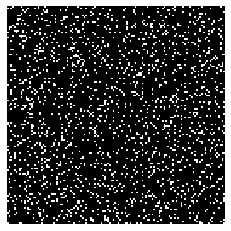

In [20]:
p = outputs_test[0].item()
# p = outputs[312].item()
print(p)
I1 = bernoulli.rvs(p, size=[size[0], size[1]])
plt.axis("off")
print(I1.shape)
plt.imshow(I1, cmap='gray')
I1 = I1.astype(np.float32)
I1 = I1.reshape([1, 1, size[0], size[1]])

Beta: 7, iteration: 0, loss: 3.98737e-04


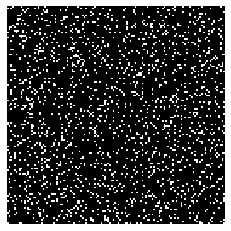

Beta: 7, iteration: 100, loss: 1.93451e-05


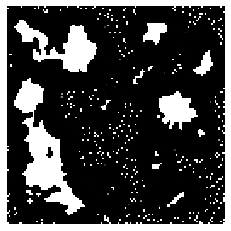

Beta: 7, iteration: 200, loss: 1.52002e-05


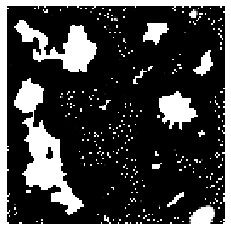

Beta: 7, iteration: 300, loss: 1.23323e-05


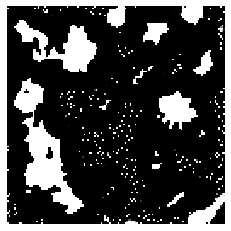

Beta: 7, iteration: 400, loss: 8.02133e-06


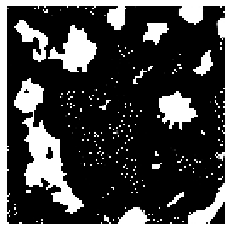

Beta: 7, iteration: 500, loss: 5.63105e-06


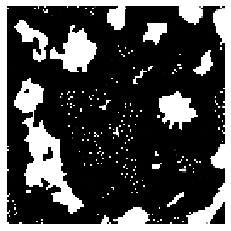

Beta: 7, iteration: 600, loss: 4.80516e-06


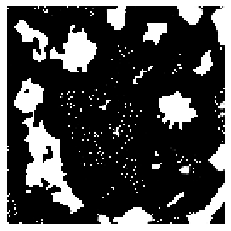

Beta: 7, iteration: 700, loss: 3.95323e-06


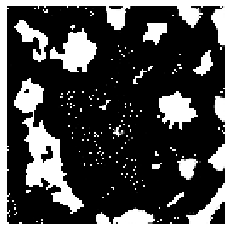

Beta: 7, iteration: 800, loss: 3.70851e-06


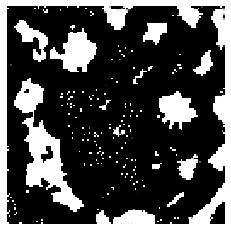

Beta: 7, iteration: 900, loss: 3.57223e-06


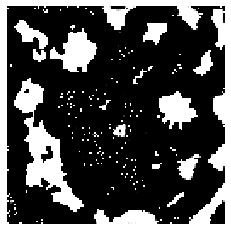

Beta: 7, iteration: 1000, loss: 3.27929e-06


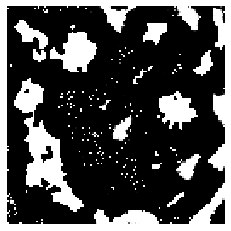

Beta: 7, iteration: 2000, loss: 2.32140e-06


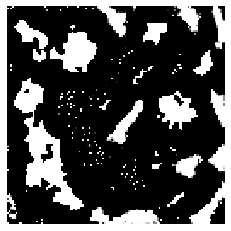

Beta: 7, iteration: 3000, loss: 2.11632e-06


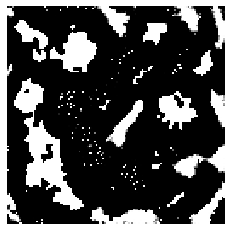

Beta: 7, iteration: 4000, loss: 1.84993e-06


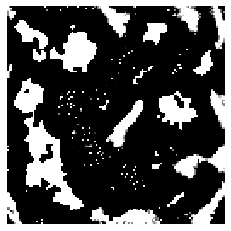

Beta: 9, iteration: 0, loss: 1.76020e-06


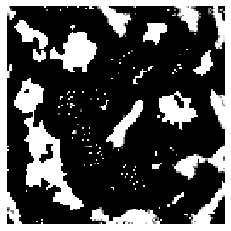

Beta: 9, iteration: 1000, loss: 1.74612e-06


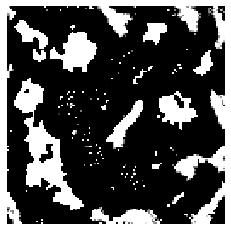

Beta: 9, iteration: 2000, loss: 1.74085e-06


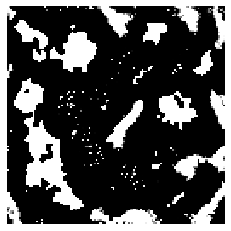

Beta: 9, iteration: 3000, loss: 1.72622e-06


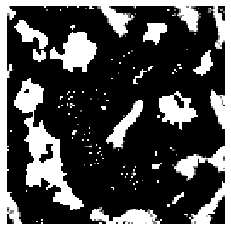

In [ ]:
weights.requires_grad = False
bias.requires_grad = False
outputs.requires_grad = False
outputs_inv.requires_grad = False
outputs = outputs.to(device)
outputs_inv = outputs_inv.to(device)
I = torch.tensor(I1, device=device)
I = Variable(I, requires_grad=True)
ones = Variable(torch.ones([1, 1, size[0], size[1]]), requires_grad=False)
ones = ones.to(device)
zeros = Variable(torch.zeros([1, 1, size[0], size[1]]), requires_grad=False)
init_I = I.detach().data
weight_filters = Variable(torch.from_numpy(weight_filter.reshape([1,1,3,3])).float(), requires_grad=False)

# I = I.to(device)
I.requires_grad = True
weight_filters = weight_filters.to(device)
for beta in [7, 9, 11, 17]:
    if beta < 11:
        iters = 5000
    elif beta < 15:
        iters = 4000
    else:
        iters = 2000
    for i in range(iters):
        
        
        cons_i = F.tanh(torch.tensor(beta/2))
        I_ = (cons_i + F.tanh(beta*I - beta/2)) / (2 * cons_i)
        out = F.conv_transpose2d(weights, I_, bias, padding=0, stride=1)
        out = F.relu(out)
        out = torch.mean(out, dim=(1,2,3))
        loss = ((out-outputs)**2).mean()

        
        with torch.no_grad():
            if beta == 7 and i % 100 == 0 and i <= 1000:
                print("Beta: {}, iteration: {}, loss: {:.5e}".format(beta, i, loss.item()))
                plt.imshow(I_.data.cpu().numpy()[0,0,:,:], cmap='gray')
                plt.axis("off")
                plt.show()
            elif i % 1000 == 0:
                print("Beta: {}, iteration: {}, loss: {:.5e}".format(beta, i, loss.item()))
                plt.imshow(I_.data.cpu().numpy()[0,0,:,:], cmap='gray')
                plt.axis("off")
                plt.show()
     
        grads = torch.autograd.grad(loss, I)
        with torch.no_grad():
            if I.grad is None:
                I.grad = grads[0].detach()
            else:
                I.grad.fill_(grads[0].detach())

            I.grad = F.conv2d(I.grad, weight_filters, padding=1, stride=1)


        if beta < 9:
            if i < 5:
                I = I - 20000000 * I.grad
            elif i < 500:
                I = I - 20000000 * I.grad
            elif i < 2000:
                I = I - 20000000 * I.grad
            elif i < 10000:
                I = I - 10000000 * I.grad
            elif i < 20000:
                I = I - 5000000 * I.grad
            else:
                I = I - 1000000 * I.grad
        else:
            if i < 2000:
                I = I - 10000000 * I.grad
            else:
                I = I - 5000000 * I.grad                